# Kernel K-Means vs Spectral Clustering

https://www.linkedin.com/pulse/kernel-k-means-vs-spectral-clustering-implementation-using-tandia/

## dataset

1. Two 100*100 images are provided, and each pixel in the image should be treated as a data point, which means there are 10000 data points in each image.

In order to run this code we have to upload two images from dataset folder.

In [ ]:
pip install array2gif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can use OpenCV to open the image and extract the pixel data into an array (1000x3), height, width, and the number of color channels (RGB) which will be used in the next function.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import sys
from scipy.spatial.distance import squareform, pdist
from array2gif import write_gif
from google.colab.patches import cv2_imshow

def load_data(path):
    image = cv2.imread(path)
    height, width, channel = image.shape
    img_array = np.zeros((width * height, channel))
    for i in range(height):
        img_array[i * width:(i + 1) * width] = image[i]

    return img_array,height,width

## THEORETICAL BACKGROUND

### Kernel Trick
Kernel method provides a way to project our data into much higher dimensional space, even equals to infinite-dimensional space, so our model can perform better in nonlinear datasets.

For both kernel k-means and spectral clustering, we will use the 2-RBF kernel defined below to compute the Gram matrix. (we can choose another kernel method )

* This new defined kernel is basically multiplying two RBF kernels in order to consider spatial similarity and color similarity at the same time. 

* S(x) is the spatial information (i.e.the coordinate of the pixel) of data x, and C(x) is the color information (i.e. the RGB values) of data x. 

* Both gamma are hyper-parameters which you can tune in 
your own way.

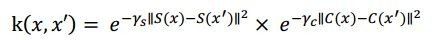

In [ ]:
def kernel_function(img_array,gamma_s,gamma_c):
    
    n=len(img_array)
    Spatial_in=np.zeros((n,2))
    for i in range(n):
        Spatial_in[i]=[i//100,i%100]
    K=squareform(np.exp(-(gamma_s)*pdist(Spatial_in,'sqeuclidean')))*squareform(np.exp(-(gamma_c)*pdist(img_array,'sqeuclidean')))

    return K


### Centroids Initialization
We need to initialize our centroid into our data space, in this case, I use two different methods such as K-Means++ Initialization and Random Initialization.

1. **K-Means++:** The main idea of this method is we pick up centroids which are the farthest from one another. This increases the chances of initially picking up centroids that lie in different clusters. Also, since centroids are picked up from the data points, each centroid has some data points associated with it at the end. 

2. **Random Init:** Random centroid initialization is one of common methods in K-Means clustering. The idea is simple, we just pick up k centroids randomly into our own data points space. For this method, I use function of normal distribution sampling method to get the centroids point from our data point, thus we need to get the mean and variance as the parameter of that function by using NumPy library. Generate the centroid with size n x k (n is our features dimension and k is our number of clusters).

In [ ]:
def initial_centroid(img_array,k,centroid_method):
    
    centroids = np.zeros((k, img_array.shape[1]))
    if centroid_method == 'kmeans++':
        centroids[0]=img_array[np.random.randint(low=0,high=img_array.shape[0],size=1),:]

        for c_id in range(1,k): 
            ## initialize a list to store distances of img_array 
            ## points from nearest centroid 
            temp_dist=np.zeros((len(img_array),c_id))
            for i in range(len(img_array)):
                for j in range(c_id):
                    temp_dist[i,j]=np.sqrt(np.sum((img_array[i]-centroids[j])**2))
                dist=np.min(temp_dist,axis=1)
                sum=np.sum(dist)*np.random.rand()
                for i in range(len(img_array)):
                    sum-=dist[i]
                    if sum<=0:
                        centroids[c_id]=img_array[i]
                        break


    elif centroid_method=='random':
        X_mean=np.mean(img_array,axis=0)
        X_std=np.std(img_array,axis=0)
        for c in range(img_array.shape[1]):
           centroids[:,c]=np.random.normal(X_mean[c],X_std[c],size=k)
        
    else:
        raise Exception ('unavailable centroid method!')

    return centroids


### K-Means Algorithm

From the name, we can infer that K-Means divide data into K-goups, in a way that data in each group are closer with each other, and share the same "mean" which represents the group. K-Means algorithm is about finding assignment of data points to clusters with the minimum sum of squares of the distances to its closest centroid.

In this code below,we made the standard K-means clustering algorithm a.k.a Lloyd’s algorithm. With the two-step process, the first is Expectation step and the second is Maximization step.

In [ ]:
def kmeans(img_array,k,H,W,centroid_method):
  
    init_mean=initial_centroid(img_array,k,centroid_method)

    class_cluster=np.zeros(len(img_array),dtype=np.uint8)
    color_map=[]
    n_iteration=1
    while True :
        # Expectation-step
        for i in range(len(img_array)):
            euc_distance=[]
            for j in range(k):
                euc_distance.append(np.sqrt(np.sum((img_array[i]-init_mean[j])**2)))
            class_cluster[i]=np.argmin(euc_distance)

        # Maximization-step
        New_Mean=np.zeros(init_mean.shape)
        for i in range(k):
            assign=np.argwhere(class_cluster==i).reshape(-1)
            for j in assign:
                New_Mean[i]=New_Mean[i]+img_array[j]
            if len(assign)>0:
                New_Mean[i]=New_Mean[i]/len(assign)

        diff = np.sum((New_Mean - init_mean)**2)
        init_mean=New_Mean
        assign_color = cluster_color(class_cluster,k,H,W)
        color_map.append(assign_color)
        
        print('Iteration {}'.format(n_iteration))
        for i in range(k):
            print('k={} : (N pixel assigned : {})'.format(i + 1, np.count_nonzero(class_cluster == i)))
        print('Difference :{}'.format(diff))
        print()
        cv2.imshow('', assign_color)
        cv2.waitKey(1)

        n_iteration+=1
        if diff<EPS:
            break
    return class_cluster,color_map,n_iteration


We initialize our centroids using the function that we specify in previous code which are k-means++ and random method. Those functions are containing the coordinate of our k centroid. And then while function as a loop for our algorithm to keep calculate the distance and assign the data points.

The first code inside the loop is the Expectation step, this step is to classify all data points according to the closest centroid we defined before, using Euclidean distance.
And then continue to the second step inside the loop which is Maximization step, this step is to update our centroids position of the points in the cluster by taking its new mean of our centroids, and also we can calculate how many data points that assigned in our new centroids as the indicator whether we need to stop or continue the process.
This process will keep iterating until the position of our old centroids and new centroids (indicate by the changing of data assigned in centroid) doesn’t have any significant difference. I also specify the difference between old mean centroid value and new mean centroid value using the mean square error.

Before we run the k-means clustering algorithm we need to choose our image, set k of centroids(clusters), gamma spatial similarity, gamma color similarity and the centroid initialization method(‘random’ or ‘k-means++’)

 The summarize of steps to do kernel K-Means are described below:

1. Compute the gram matrix of our image data array using our kernel inside kernel_function().
2. Initialize the centroids.
3. Get into the k-means clustering algorithm.

## Spectral Clustering
Spetral clustering is about finding the cluster in a graph form, it can find clusters of almost arbitrary shape e.g. intertwined, spirals, etc. because it has the criteria of connectivity instead of compactness. For the algorithm, we refers to this paper https://arxiv.org/abs/0711.0189 .


### Normalized Spectral Clustering

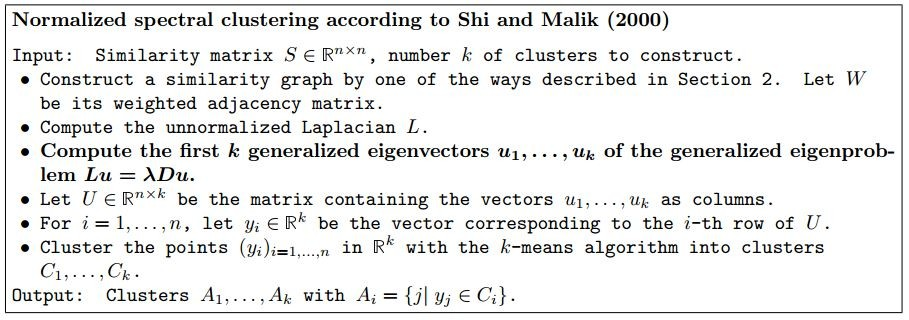

First, we need to find the Laplacian matrix by the substraction of degree matrix D and similarity matrix W. Similarity matrix we get from the kernel_function and the degree matrix we get from the sum of diagonal similarity matrix. Because this is normalized spectral clustering, the second is we need to find the normalized form of our Laplacian matrix, this is can be done by using this formula.

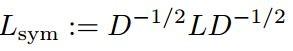

After we calculate the normalized Laplacian Lsym­­ , we can search for the eigenvalue and eigenspace of it by using the numpy function. 

Next is compute the matrix T from eigenvector U by normalizing the rows of U to norm 1. The last, we just plug in the matrix T into our k-means algorithm.

### Unnormalized Spectral Clustering (Ratio Cut)
Algorithm:

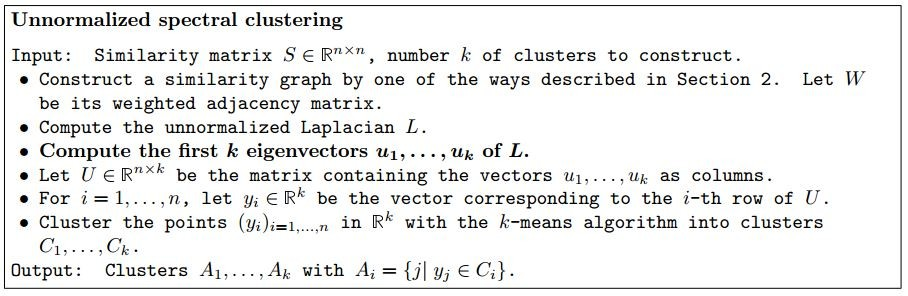

For ratio cut spectral clustering, we don’t need to calculate the normalized term of Laplacian. Thus, after get the Laplacian graph matrix using this formula.

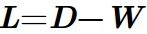

Then we just directly searching for its eigenvalue and eigenvector. And eigenvector matrix U will plug into the k-means algorithm to cluster the image data points.

# Results
Based on the results, normalized spectral clustering can achieve a better clustering result due to the properties of fix biased by normalized the size of segments and because of the image2 have a little spread of color pixel values (unlike the image1 that have the color pixel values with a big difference in one area and another). 

So the normalized term can distinguish the image data in more detail than the unnormalized and the kernel k-means.

In [ ]:
from google.colab.patches import cv2_imshow

def kernel_function(img_array,gamma_s,gamma_c):
    
    n=len(img_array)
    Spatial_in=np.zeros((n,2))
    for i in range(n):
        Spatial_in[i]=[i//100,i%100]
    K=squareform(np.exp( gamma_s*pdist(Spatial_in,'sqeuclidean')))*squareform(np.exp(-gamma_c*pdist(img_array,'sqeuclidean')))
    return K


def initial_centroid(img_array,k,centroid_method):
    
    centroids = np.zeros((k, img_array.shape[1]))
    if centroid_method == 'kmeans++':
        centroids[0]=img_array[np.random.randint(low=0,high=img_array.shape[0],size=1),:]

        for c_id in range(1,k): 
            ## initialize a list to store distances of img_array 
            ## points from nearest centroid 
            temp_dist=np.zeros((len(img_array),c_id))
            for i in range(len(img_array)):
                for j in range(c_id):
                    temp_dist[i,j]=np.sqrt(np.sum((img_array[i]-centroids[j])**2))
                dist=np.min(temp_dist,axis=1)
                sum=np.sum(dist)*np.random.rand()
                for i in range(len(img_array)):
                    sum-=dist[i]
                    if sum<=0:
                        centroids[c_id]=img_array[i]
                        break


    elif centroid_method=='random':
        X_mean=np.mean(img_array,axis=0)
        X_std=np.std(img_array,axis=0)
        for c in range(img_array.shape[1]):
           centroids[:,c]=np.random.normal(X_mean[c],X_std[c],size=k)
        
    else:
        raise Exception ('unavailable centroid method!')

    return centroids

def kmeans(img_array,k,H,W,centroid_method):
    from google.colab.patches import cv2_imshow
    init_mean=initial_centroid(img_array,k,centroid_method)

    class_cluster=np.zeros(len(img_array),dtype=np.uint8)
    color_map=[]
    n_iteration=1
    while True :
        # Expectation-step
        for i in range(len(img_array)):
            euc_distance=[]
            for j in range(k):
                euc_distance.append(np.sqrt(np.sum((img_array[i]-init_mean[j])**2)))
            class_cluster[i]=np.argmin(euc_distance)

        # Maximization-step
        New_Mean=np.zeros(init_mean.shape)
        for i in range(k):
            assign=np.argwhere(class_cluster==i).reshape(-1)
            for j in assign:
                New_Mean[i]=New_Mean[i]+img_array[j]
            if len(assign)>0:
                New_Mean[i]=New_Mean[i]/len(assign)

        diff = np.sum((New_Mean - init_mean)**2)
        init_mean=New_Mean
        assign_color = cluster_color(class_cluster,k,H,W)
        color_map.append(assign_color)
        
        print('Iteration {}'.format(n_iteration))
        for i in range(k):
            print('k={} : (N pixel assigned : {})'.format(i + 1, np.count_nonzero(class_cluster == i)))
        print('Difference :{}'.format(diff))
        print()
        cv2_imshow(assign_color)
        cv2.waitKey(1)

        n_iteration +=1
        if diff<EPS:
            break
    return class_cluster,color_map,n_iteration

def cluster_color(img_array,k,H,W):
    
    if k >=5:
         cluster_color= np.random.choice(range(256),size=(k,3))
    elif k ==2 :
        cluster_color = np.array([[0,255,0],[0,0,255]])
    elif k == 3:
        cluster_color = np.array([[255,0,0],[0,255,0],[0,0,255]])
    elif k == 4:
        cluster_color = np.array([[255,0,0],[0,255,0],[0,0,255],[255,255,0]])
    
    res=np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            res[h,w,:]=cluster_color[img_array[h*W+w]]
    return res.astype(np.uint8)


In [ ]:
def plot3D_eigenspace_laplacian(x_axis,y_axis,z_axis,class_cluster):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    markers=['o','^','s']
    for marker,i in zip(markers,np.arange(3)):
        ax.scatter(x_axis[class_cluster==i],y_axis[class_cluster==i],z_axis[class_cluster==i],marker=marker)
    plt.title('3D representation of Eigenspace coordinates')
    ax.set_xlabel('1st Eigenvector')
    ax.set_ylabel('2nd Eigenvector')
    ax.set_zlabel('3rd Eigenvector')
    plt.show()

def plot2D_eigenspace_laplacian(x_axis,y_axis,z_axis,class_cluster):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    colors=['blue','orange']
    for colors,i in zip(colors,np.arange(2)):
        ax.scatter(x_axis[class_cluster==i],y_axis[class_cluster==i],c=colors,s=3)
    plt.title('2D representation of Eigenspace coordinates')
    ax.set_xlabel('1st Eigenvector')
    ax.set_ylabel('2nd Eigenvector')
    plt.show()

Choose image (1 or 2) :
1
set n cluster:
3
set gamma spatial similarity:
0.00007
set gamma color similarity:
0.00007
Choose a Clustering Method: 
 1:Kernel K-means, 	2:Normalized Spectral Clustering, 	3:Ratio Cut Spectral Clustering:
 1
Clustering the image...
Iteration 1
k=1 : (N pixel assigned : 3740)
k=2 : (N pixel assigned : 1534)
k=3 : (N pixel assigned : 4726)
Difference :1172.7094313974612



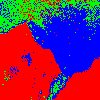

Iteration 2
k=1 : (N pixel assigned : 3526)
k=2 : (N pixel assigned : 1780)
k=3 : (N pixel assigned : 4694)
Difference :51.40663529199862



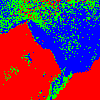

Iteration 3
k=1 : (N pixel assigned : 3592)
k=2 : (N pixel assigned : 1788)
k=3 : (N pixel assigned : 4620)
Difference :18.579831316407112



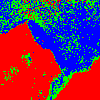

Iteration 4
k=1 : (N pixel assigned : 3761)
k=2 : (N pixel assigned : 1688)
k=3 : (N pixel assigned : 4551)
Difference :9.746667182516168



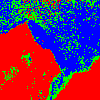

Iteration 5
k=1 : (N pixel assigned : 3957)
k=2 : (N pixel assigned : 1530)
k=3 : (N pixel assigned : 4513)
Difference :8.206950084831355



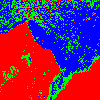

Iteration 6
k=1 : (N pixel assigned : 4127)
k=2 : (N pixel assigned : 1417)
k=3 : (N pixel assigned : 4456)
Difference :10.517330580479245



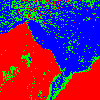

Iteration 7
k=1 : (N pixel assigned : 4267)
k=2 : (N pixel assigned : 1332)
k=3 : (N pixel assigned : 4401)
Difference :9.56312136222985



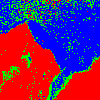

Iteration 8
k=1 : (N pixel assigned : 4394)
k=2 : (N pixel assigned : 1250)
k=3 : (N pixel assigned : 4356)
Difference :8.949820929639571



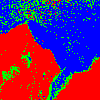

Iteration 9
k=1 : (N pixel assigned : 4479)
k=2 : (N pixel assigned : 1226)
k=3 : (N pixel assigned : 4295)
Difference :7.3776010172189785



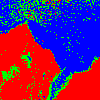

Iteration 10
k=1 : (N pixel assigned : 4545)
k=2 : (N pixel assigned : 1205)
k=3 : (N pixel assigned : 4250)
Difference :4.566609057807525



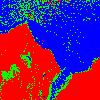

Iteration 11
k=1 : (N pixel assigned : 4594)
k=2 : (N pixel assigned : 1207)
k=3 : (N pixel assigned : 4199)
Difference :3.8975250968778883



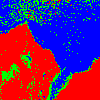

Iteration 12
k=1 : (N pixel assigned : 4635)
k=2 : (N pixel assigned : 1221)
k=3 : (N pixel assigned : 4144)
Difference :3.675333833054324



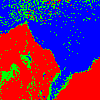

Iteration 13
k=1 : (N pixel assigned : 4668)
k=2 : (N pixel assigned : 1235)
k=3 : (N pixel assigned : 4097)
Difference :2.47372824275389



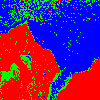

Iteration 14
k=1 : (N pixel assigned : 4695)
k=2 : (N pixel assigned : 1256)
k=3 : (N pixel assigned : 4049)
Difference :2.2697352471688244



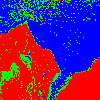

Iteration 15
k=1 : (N pixel assigned : 4724)
k=2 : (N pixel assigned : 1265)
k=3 : (N pixel assigned : 4011)
Difference :1.7756188051539408



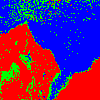

Iteration 16
k=1 : (N pixel assigned : 4746)
k=2 : (N pixel assigned : 1279)
k=3 : (N pixel assigned : 3975)
Difference :1.2283290737002028



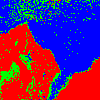

Iteration 17
k=1 : (N pixel assigned : 4763)
k=2 : (N pixel assigned : 1301)
k=3 : (N pixel assigned : 3936)
Difference :1.2166994112328167



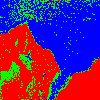

Iteration 18
k=1 : (N pixel assigned : 4784)
k=2 : (N pixel assigned : 1305)
k=3 : (N pixel assigned : 3911)
Difference :0.8074930920903824



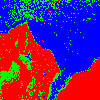

Iteration 19
k=1 : (N pixel assigned : 4804)
k=2 : (N pixel assigned : 1313)
k=3 : (N pixel assigned : 3883)
Difference :0.8519439918905415



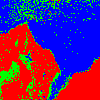

Iteration 20
k=1 : (N pixel assigned : 4818)
k=2 : (N pixel assigned : 1330)
k=3 : (N pixel assigned : 3852)
Difference :0.7240151704464486



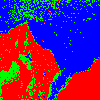

Iteration 21
k=1 : (N pixel assigned : 4829)
k=2 : (N pixel assigned : 1344)
k=3 : (N pixel assigned : 3827)
Difference :0.42328592287035216



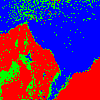

Iteration 22
k=1 : (N pixel assigned : 4841)
k=2 : (N pixel assigned : 1354)
k=3 : (N pixel assigned : 3805)
Difference :0.42912195231358674



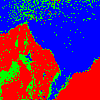

Iteration 23
k=1 : (N pixel assigned : 4855)
k=2 : (N pixel assigned : 1370)
k=3 : (N pixel assigned : 3775)
Difference :0.6636067116168267



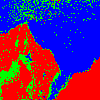

Iteration 24
k=1 : (N pixel assigned : 4866)
k=2 : (N pixel assigned : 1403)
k=3 : (N pixel assigned : 3731)
Difference :0.9615913957120878



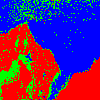

Iteration 25
k=1 : (N pixel assigned : 4882)
k=2 : (N pixel assigned : 1440)
k=3 : (N pixel assigned : 3678)
Difference :1.4332398246691476



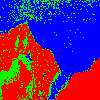

Iteration 26
k=1 : (N pixel assigned : 4900)
k=2 : (N pixel assigned : 1481)
k=3 : (N pixel assigned : 3619)
Difference :1.810493739184907



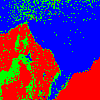

Iteration 27
k=1 : (N pixel assigned : 4916)
k=2 : (N pixel assigned : 1536)
k=3 : (N pixel assigned : 3548)
Difference :2.063322009565099



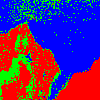

Iteration 28
k=1 : (N pixel assigned : 4930)
k=2 : (N pixel assigned : 1610)
k=3 : (N pixel assigned : 3460)
Difference :2.5632601370922496



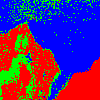

Iteration 29
k=1 : (N pixel assigned : 4949)
k=2 : (N pixel assigned : 1698)
k=3 : (N pixel assigned : 3353)
Difference :3.8299535587479427



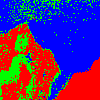

Iteration 30
k=1 : (N pixel assigned : 4971)
k=2 : (N pixel assigned : 1788)
k=3 : (N pixel assigned : 3241)
Difference :4.140723259349994



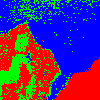

Iteration 31
k=1 : (N pixel assigned : 5001)
k=2 : (N pixel assigned : 1902)
k=3 : (N pixel assigned : 3097)
Difference :6.316175880166637



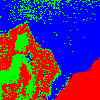

Iteration 32
k=1 : (N pixel assigned : 5025)
k=2 : (N pixel assigned : 2047)
k=3 : (N pixel assigned : 2928)
Difference :7.3805529175728735



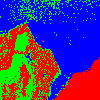

Iteration 33
k=1 : (N pixel assigned : 5053)
k=2 : (N pixel assigned : 2223)
k=3 : (N pixel assigned : 2724)
Difference :10.192417692725103



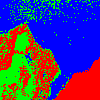

Iteration 34
k=1 : (N pixel assigned : 5088)
k=2 : (N pixel assigned : 2413)
k=3 : (N pixel assigned : 2499)
Difference :13.397157294035578



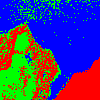

Iteration 35
k=1 : (N pixel assigned : 5118)
k=2 : (N pixel assigned : 2629)
k=3 : (N pixel assigned : 2253)
Difference :16.43424960752056



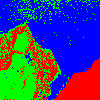

Iteration 36
k=1 : (N pixel assigned : 5136)
k=2 : (N pixel assigned : 2822)
k=3 : (N pixel assigned : 2042)
Difference :15.056816108811768



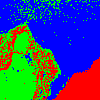

Iteration 37
k=1 : (N pixel assigned : 5156)
k=2 : (N pixel assigned : 2962)
k=3 : (N pixel assigned : 1882)
Difference :11.292051040454517



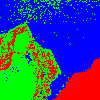

Iteration 38
k=1 : (N pixel assigned : 5182)
k=2 : (N pixel assigned : 3105)
k=3 : (N pixel assigned : 1713)
Difference :14.416048009267236



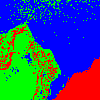

Iteration 39
k=1 : (N pixel assigned : 5203)
k=2 : (N pixel assigned : 3297)
k=3 : (N pixel assigned : 1500)
Difference :31.984407554791417



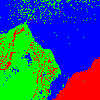

Iteration 40
k=1 : (N pixel assigned : 5226)
k=2 : (N pixel assigned : 3591)
k=3 : (N pixel assigned : 1183)
Difference :107.34480489883775



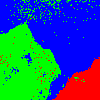

Iteration 41
k=1 : (N pixel assigned : 5245)
k=2 : (N pixel assigned : 3632)
k=3 : (N pixel assigned : 1123)
Difference :9.112979436279026



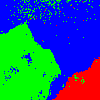

Iteration 42
k=1 : (N pixel assigned : 5246)
k=2 : (N pixel assigned : 3630)
k=3 : (N pixel assigned : 1124)
Difference :0.03618531247454654



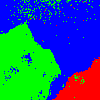

Iteration 43
k=1 : (N pixel assigned : 5246)
k=2 : (N pixel assigned : 3632)
k=3 : (N pixel assigned : 1122)
Difference :0.00232658063616525



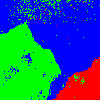

Iteration 44
k=1 : (N pixel assigned : 5246)
k=2 : (N pixel assigned : 3632)
k=3 : (N pixel assigned : 1122)
Difference :0.0



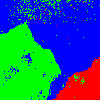

time needed for eigen decomposition:  76.0  s


In [ ]:
def process_gif(color_map,gif_path):
    for i in range(len(color_map)):
        color_map[i] = color_map[i].transpose(1, 0, 2)
    write_gif(color_map, gif_path, fps=2)

if __name__ == "__main__":
       
    print('Choose image (1 or 2) :')
    inp = int(input())
    print('set n cluster:')
    k = int(input())
    
    print('set gamma spatial similarity:')
    gamma_s=float(input())
    
    print('set gamma color similarity:')
    gamma_c=float(input())

    file_path='image'+str(inp)+'.png'
    img_array,height,width=load_data(file_path)

    initCentroid_method='kmeans++'

    # # # k=3  # k clusters
    # gamma_c =0.00007
    # gamma_s =0.00007
    
    EPS=1e-8
    mode=input('Choose a Clustering Method: \n 1:Kernel K-means, \t2:Normalized Spectral Clustering, \t3:Ratio Cut Spectral Clustering:\n ')
    if mode=='1':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        Gram=kernel_function(img_array,gamma_s,gamma_c)
        assigned_pixel,color_map,n_iteration=kmeans(Gram,k,height,width,centroid_method=initCentroid_method)
                
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'kernel k-means.gif'))
        process_gif(color_map,save_path)
    
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='2':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        L=D-W
        D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
        L_sym=D_inverse_square_root@L@D_inverse_square_root

        eigenvalue,eigenvector=np.linalg.eig(L_sym)
        sort_index=np.argsort(eigenvalue)
        # U:(n,k)
        U=eigenvector[:,sort_index[1:1+k]]
        # T:(n,k) each row with norm 1
        sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
        T=U/sums

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(T,k,height,width,centroid_method=initCentroid_method)
        
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'Normalized_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        if k==3:
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='3':
        
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')

        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        #laplacian grah matrix
        L=D-W
        eigenvalue,eigenvector=np.linalg.eig(L)
        sort_index=np.argsort(eigenvalue)
        # U = eigenvector matrix nxk
        U=eigenvector[:,sort_index[1:1+k]]

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(U,k,height,width,centroid_method=initCentroid_method)

        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'RatioCut_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        
        if k==3 :
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else: print('task is not recognized!')

Choose image (1 or 2) :
set n cluster:
set gamma spatial similarity:
set gamma color similarity:
Clustering the image...
Iteration 1
k=1 : (N pixel assigned : 4090)
k=2 : (N pixel assigned : 4921)
k=3 : (N pixel assigned : 989)
Difference :1.5699660246161493



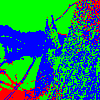

Iteration 2
k=1 : (N pixel assigned : 4127)
k=2 : (N pixel assigned : 4481)
k=3 : (N pixel assigned : 1392)
Difference :0.020768161129179962



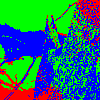

Iteration 3
k=1 : (N pixel assigned : 4302)
k=2 : (N pixel assigned : 4454)
k=3 : (N pixel assigned : 1244)
Difference :0.08855390947822851



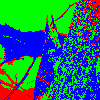

Iteration 4
k=1 : (N pixel assigned : 4442)
k=2 : (N pixel assigned : 4300)
k=3 : (N pixel assigned : 1258)
Difference :0.0318984726454606



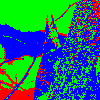

Iteration 5
k=1 : (N pixel assigned : 4874)
k=2 : (N pixel assigned : 3811)
k=3 : (N pixel assigned : 1315)
Difference :0.04859964579769046



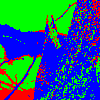

Iteration 6
k=1 : (N pixel assigned : 4905)
k=2 : (N pixel assigned : 3674)
k=3 : (N pixel assigned : 1421)
Difference :0.013404393091005336



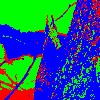

Iteration 7
k=1 : (N pixel assigned : 4753)
k=2 : (N pixel assigned : 3693)
k=3 : (N pixel assigned : 1554)
Difference :0.008327474706040927



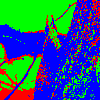

Iteration 8
k=1 : (N pixel assigned : 4599)
k=2 : (N pixel assigned : 3701)
k=3 : (N pixel assigned : 1700)
Difference :0.008066978811439474



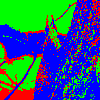

Iteration 9
k=1 : (N pixel assigned : 4398)
k=2 : (N pixel assigned : 3704)
k=3 : (N pixel assigned : 1898)
Difference :0.011354856753652526



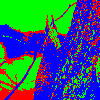

Iteration 10
k=1 : (N pixel assigned : 4064)
k=2 : (N pixel assigned : 3718)
k=3 : (N pixel assigned : 2218)
Difference :0.024891278047442407



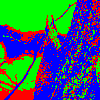

Iteration 11
k=1 : (N pixel assigned : 3533)
k=2 : (N pixel assigned : 3743)
k=3 : (N pixel assigned : 2724)
Difference :0.0469511608994956



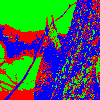

Iteration 12
k=1 : (N pixel assigned : 3026)
k=2 : (N pixel assigned : 3795)
k=3 : (N pixel assigned : 3179)
Difference :0.04131458856504336



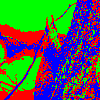

Iteration 13
k=1 : (N pixel assigned : 2715)
k=2 : (N pixel assigned : 3853)
k=3 : (N pixel assigned : 3432)
Difference :0.017746220991346092



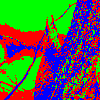

Iteration 14
k=1 : (N pixel assigned : 2543)
k=2 : (N pixel assigned : 3894)
k=3 : (N pixel assigned : 3563)
Difference :0.005660362549691425



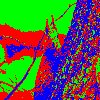

Iteration 15
k=1 : (N pixel assigned : 2457)
k=2 : (N pixel assigned : 3917)
k=3 : (N pixel assigned : 3626)
Difference :0.0014545647832573847



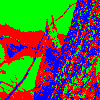

Iteration 16
k=1 : (N pixel assigned : 2427)
k=2 : (N pixel assigned : 3935)
k=3 : (N pixel assigned : 3638)
Difference :0.00025571580134792167



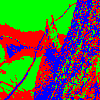

Iteration 17
k=1 : (N pixel assigned : 2410)
k=2 : (N pixel assigned : 3944)
k=3 : (N pixel assigned : 3646)
Difference :7.177320925488832e-05



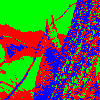

Iteration 18
k=1 : (N pixel assigned : 2404)
k=2 : (N pixel assigned : 3945)
k=3 : (N pixel assigned : 3651)
Difference :6.920934616289163e-06



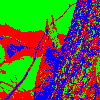

Iteration 19
k=1 : (N pixel assigned : 2401)
k=2 : (N pixel assigned : 3946)
k=3 : (N pixel assigned : 3653)
Difference :2.111821082974707e-06



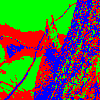

Iteration 20
k=1 : (N pixel assigned : 2401)
k=2 : (N pixel assigned : 3946)
k=3 : (N pixel assigned : 3653)
Difference :0.0



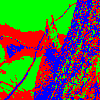

time needed for eigen decomposition:  1050.0  s


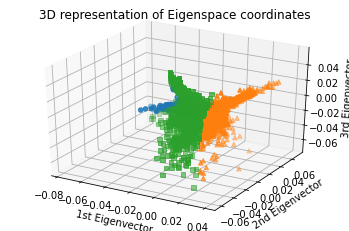

In [ ]:
def process_gif(color_map,gif_path):
    for i in range(len(color_map)):
        color_map[i] = color_map[i].transpose(1, 0, 2)
    write_gif(color_map, gif_path, fps=2)

if __name__ == "__main__":
       
    print('Choose image (1 or 2) :')
    inp = int(input())
    print('set n cluster:')
    k = int(input())
    
    print('set gamma spatial similarity:')
    gamma_s=float(input())
    
    print('set gamma color similarity:')
    gamma_c=float(input())

    file_path='image'+str(inp)+'.png'
    img_array,height,width=load_data(file_path)

    initCentroid_method='kmeans++'

    # # # k=3  # k clusters
    # gamma_c =0.00007
    # gamma_s =0.00007
    
    EPS=1e-8
    mode=input('Choose a Clustering Method: \n 1:Kernel K-means, \t2:Normalized Spectral Clustering, \t3:Ratio Cut Spectral Clustering:\n ')
    if mode=='1':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        Gram=kernel_function(img_array,gamma_s,gamma_c)
        assigned_pixel,color_map,n_iteration=kmeans(Gram,k,height,width,centroid_method=initCentroid_method)
                
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'kernel k-means.gif'))
        process_gif(color_map,save_path)
    
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='2':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        L=D-W
        D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
        L_sym=D_inverse_square_root@L@D_inverse_square_root

        eigenvalue,eigenvector=np.linalg.eig(L_sym)
        sort_index=np.argsort(eigenvalue)
        # U:(n,k)
        U=eigenvector[:,sort_index[1:1+k]]
        # T:(n,k) each row with norm 1
        sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
        T=U/sums

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(T,k,height,width,centroid_method=initCentroid_method)
        
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'Normalized_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        if k==3:
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='3':
        
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')

        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        #laplacian grah matrix
        L=D-W
        eigenvalue,eigenvector=np.linalg.eig(L)
        sort_index=np.argsort(eigenvalue)
        # U = eigenvector matrix nxk
        U=eigenvector[:,sort_index[1:1+k]]

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(U,k,height,width,centroid_method=initCentroid_method)

        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'RatioCut_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        
        if k==3 :
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else: print('task is not recognized!')

Choose image (1 or 2) :
2
set n cluster:
3
set gamma spatial similarity:
0.0005
set gamma color similarity:
0.0003
Choose a Clustering Method: 
 1:Kernel K-means, 	2:Normalized Spectral Clustering, 	3:Ratio Cut Spectral Clustering:
 2
Clustering the image...
Iteration 1
k=1 : (N pixel assigned : 2621)
k=2 : (N pixel assigned : 4732)
k=3 : (N pixel assigned : 2647)
Difference :1.3389416232835396



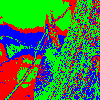

Iteration 2
k=1 : (N pixel assigned : 3158)
k=2 : (N pixel assigned : 4661)
k=3 : (N pixel assigned : 2181)
Difference :0.032372999982693405



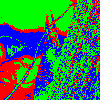

Iteration 3
k=1 : (N pixel assigned : 3316)
k=2 : (N pixel assigned : 4838)
k=3 : (N pixel assigned : 1846)
Difference :0.03647986375874961



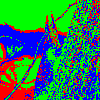

Iteration 4
k=1 : (N pixel assigned : 3394)
k=2 : (N pixel assigned : 4952)
k=3 : (N pixel assigned : 1654)
Difference :0.03046747325295262



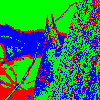

Iteration 5
k=1 : (N pixel assigned : 3441)
k=2 : (N pixel assigned : 4974)
k=3 : (N pixel assigned : 1585)
Difference :0.01415139336109595



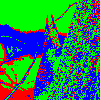

Iteration 6
k=1 : (N pixel assigned : 3487)
k=2 : (N pixel assigned : 4966)
k=3 : (N pixel assigned : 1547)
Difference :0.007973395565165093



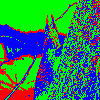

Iteration 7
k=1 : (N pixel assigned : 3528)
k=2 : (N pixel assigned : 4938)
k=3 : (N pixel assigned : 1534)
Difference :0.003886814925745113



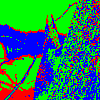

Iteration 8
k=1 : (N pixel assigned : 3571)
k=2 : (N pixel assigned : 4888)
k=3 : (N pixel assigned : 1541)
Difference :0.0020144936135320555



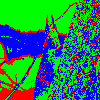

Iteration 9
k=1 : (N pixel assigned : 3591)
k=2 : (N pixel assigned : 4856)
k=3 : (N pixel assigned : 1553)
Difference :0.0008746137746084384



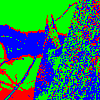

Iteration 10
k=1 : (N pixel assigned : 3626)
k=2 : (N pixel assigned : 4819)
k=3 : (N pixel assigned : 1555)
Difference :0.0005458691745274961



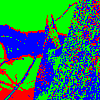

Iteration 11
k=1 : (N pixel assigned : 3663)
k=2 : (N pixel assigned : 4775)
k=3 : (N pixel assigned : 1562)
Difference :0.0004372409379378799



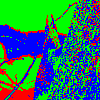

Iteration 12
k=1 : (N pixel assigned : 3696)
k=2 : (N pixel assigned : 4737)
k=3 : (N pixel assigned : 1567)
Difference :0.0003282201888945583



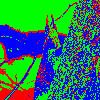

Iteration 13
k=1 : (N pixel assigned : 3733)
k=2 : (N pixel assigned : 4694)
k=3 : (N pixel assigned : 1573)
Difference :0.0003791578972180836



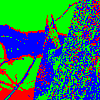

Iteration 14
k=1 : (N pixel assigned : 3768)
k=2 : (N pixel assigned : 4652)
k=3 : (N pixel assigned : 1580)
Difference :0.0004802612728436905



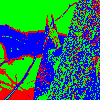

Iteration 15
k=1 : (N pixel assigned : 3801)
k=2 : (N pixel assigned : 4606)
k=3 : (N pixel assigned : 1593)
Difference :0.000697155990841109



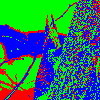

Iteration 16
k=1 : (N pixel assigned : 3848)
k=2 : (N pixel assigned : 4547)
k=3 : (N pixel assigned : 1605)
Difference :0.0008348152203631507



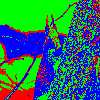

Iteration 17
k=1 : (N pixel assigned : 3910)
k=2 : (N pixel assigned : 4462)
k=3 : (N pixel assigned : 1628)
Difference :0.0019694654757074536



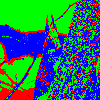

Iteration 18
k=1 : (N pixel assigned : 4027)
k=2 : (N pixel assigned : 4323)
k=3 : (N pixel assigned : 1650)
Difference :0.004155496440090498



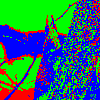

Iteration 19
k=1 : (N pixel assigned : 4310)
k=2 : (N pixel assigned : 4001)
k=3 : (N pixel assigned : 1689)
Difference :0.019702958172003522



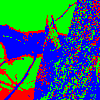

Iteration 20
k=1 : (N pixel assigned : 4666)
k=2 : (N pixel assigned : 3590)
k=3 : (N pixel assigned : 1744)
Difference :0.03737972613802359



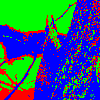

Iteration 21
k=1 : (N pixel assigned : 4548)
k=2 : (N pixel assigned : 3585)
k=3 : (N pixel assigned : 1867)
Difference :0.0037616489801800754



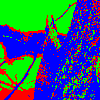

Iteration 22
k=1 : (N pixel assigned : 4447)
k=2 : (N pixel assigned : 3594)
k=3 : (N pixel assigned : 1959)
Difference :0.0030596479029399446



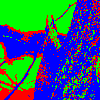

Iteration 23
k=1 : (N pixel assigned : 4356)
k=2 : (N pixel assigned : 3609)
k=3 : (N pixel assigned : 2035)
Difference :0.0025100663687708867



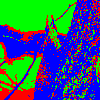

Iteration 24
k=1 : (N pixel assigned : 4262)
k=2 : (N pixel assigned : 3619)
k=3 : (N pixel assigned : 2119)
Difference :0.0023857408948467535



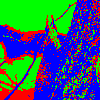

Iteration 25
k=1 : (N pixel assigned : 4165)
k=2 : (N pixel assigned : 3633)
k=3 : (N pixel assigned : 2202)
Difference :0.0025177195432915097



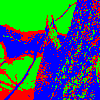

Iteration 26
k=1 : (N pixel assigned : 4052)
k=2 : (N pixel assigned : 3649)
k=3 : (N pixel assigned : 2299)
Difference :0.0031551205634074778



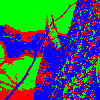

Iteration 27
k=1 : (N pixel assigned : 3884)
k=2 : (N pixel assigned : 3661)
k=3 : (N pixel assigned : 2455)
Difference :0.0057724925500378405



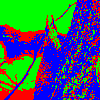

Iteration 28
k=1 : (N pixel assigned : 3658)
k=2 : (N pixel assigned : 3679)
k=3 : (N pixel assigned : 2663)
Difference :0.009829389872423686



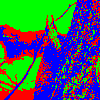

Iteration 29
k=1 : (N pixel assigned : 3371)
k=2 : (N pixel assigned : 3701)
k=3 : (N pixel assigned : 2928)
Difference :0.014809145671772033



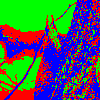

Iteration 30
k=1 : (N pixel assigned : 3095)
k=2 : (N pixel assigned : 3723)
k=3 : (N pixel assigned : 3182)
Difference :0.013555924511369992



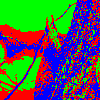

Iteration 31
k=1 : (N pixel assigned : 2841)
k=2 : (N pixel assigned : 3756)
k=3 : (N pixel assigned : 3403)
Difference :0.01250939449227048



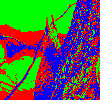

Iteration 32
k=1 : (N pixel assigned : 2630)
k=2 : (N pixel assigned : 3801)
k=3 : (N pixel assigned : 3569)
Difference :0.009681419210037625



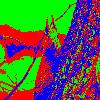

Iteration 33
k=1 : (N pixel assigned : 2477)
k=2 : (N pixel assigned : 3848)
k=3 : (N pixel assigned : 3675)
Difference :0.005767819452718451



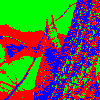

Iteration 34
k=1 : (N pixel assigned : 2391)
k=2 : (N pixel assigned : 3878)
k=3 : (N pixel assigned : 3731)
Difference :0.0019450554820292219



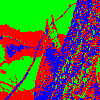

Iteration 35
k=1 : (N pixel assigned : 2355)
k=2 : (N pixel assigned : 3894)
k=3 : (N pixel assigned : 3751)
Difference :0.00035774832915306566



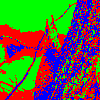

Iteration 36
k=1 : (N pixel assigned : 2337)
k=2 : (N pixel assigned : 3900)
k=3 : (N pixel assigned : 3763)
Difference :8.158101573761463e-05



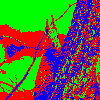

Iteration 37
k=1 : (N pixel assigned : 2329)
k=2 : (N pixel assigned : 3905)
k=3 : (N pixel assigned : 3766)
Difference :2.2374461454887278e-05



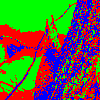

Iteration 38
k=1 : (N pixel assigned : 2323)
k=2 : (N pixel assigned : 3910)
k=3 : (N pixel assigned : 3767)
Difference :1.586809534852057e-05



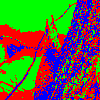

Iteration 39
k=1 : (N pixel assigned : 2319)
k=2 : (N pixel assigned : 3911)
k=3 : (N pixel assigned : 3770)
Difference :3.8094828268083475e-06



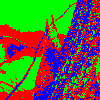

Iteration 40
k=1 : (N pixel assigned : 2318)
k=2 : (N pixel assigned : 3913)
k=3 : (N pixel assigned : 3769)
Difference :1.3336035013129839e-06



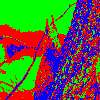

Iteration 41
k=1 : (N pixel assigned : 2317)
k=2 : (N pixel assigned : 3914)
k=3 : (N pixel assigned : 3769)
Difference :4.350108164610108e-07



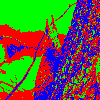

Iteration 42
k=1 : (N pixel assigned : 2317)
k=2 : (N pixel assigned : 3915)
k=3 : (N pixel assigned : 3768)
Difference :2.470935085038512e-07



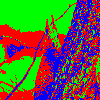

Iteration 43
k=1 : (N pixel assigned : 2316)
k=2 : (N pixel assigned : 3915)
k=3 : (N pixel assigned : 3769)
Difference :2.067599697328268e-07



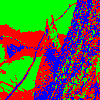

Iteration 44
k=1 : (N pixel assigned : 2315)
k=2 : (N pixel assigned : 3915)
k=3 : (N pixel assigned : 3770)
Difference :1.989253370630202e-07



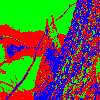

Iteration 45
k=1 : (N pixel assigned : 2314)
k=2 : (N pixel assigned : 3915)
k=3 : (N pixel assigned : 3771)
Difference :1.9725025484773007e-07



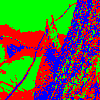

Iteration 46
k=1 : (N pixel assigned : 2314)
k=2 : (N pixel assigned : 3915)
k=3 : (N pixel assigned : 3771)
Difference :0.0



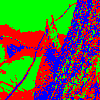

time needed for eigen decomposition:  1077.0  s


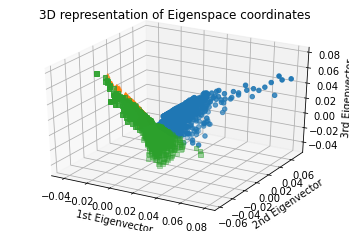

In [11]:
def process_gif(color_map,gif_path):
    for i in range(len(color_map)):
        color_map[i] = color_map[i].transpose(1, 0, 2)
    write_gif(color_map, gif_path, fps=2)

if __name__ == "__main__":
       
    print('Choose image (1 or 2) :')
    inp = int(input())
    print('set n cluster:')
    k = int(input())
    
    print('set gamma spatial similarity:')
    gamma_s=float(input())
    
    print('set gamma color similarity:')
    gamma_c=float(input())

    file_path='image'+str(inp)+'.png'
    img_array,height,width=load_data(file_path)

    initCentroid_method='kmeans++'

    # # # k=3  # k clusters
    # gamma_c =0.00007
    # gamma_s =0.00007
    
    EPS=1e-8
    mode=input('Choose a Clustering Method: \n 1:Kernel K-means, \t2:Normalized Spectral Clustering, \t3:Ratio Cut Spectral Clustering:\n ')
    if mode=='1':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        Gram=kernel_function(img_array,gamma_s,gamma_c)
        assigned_pixel,color_map,n_iteration=kmeans(Gram,k,height,width,centroid_method=initCentroid_method)
                
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'kernel k-means.gif'))
        process_gif(color_map,save_path)
    
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='2':
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')
        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        L=D-W
        D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
        L_sym=D_inverse_square_root@L@D_inverse_square_root

        eigenvalue,eigenvector=np.linalg.eig(L_sym)
        sort_index=np.argsort(eigenvalue)
        # U:(n,k)
        U=eigenvector[:,sort_index[1:1+k]]
        # T:(n,k) each row with norm 1
        sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
        T=U/sums

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(T,k,height,width,centroid_method=initCentroid_method)
        
        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'Normalized_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        if k==3:
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif mode=='3':
        
        start = np.around(time.time(), decimals=0)
        print('Clustering the image...')

        # similarity matrix
        W=kernel_function(img_array,gamma_s,gamma_c)
        # degree matrix
        D=np.diag(np.sum(W,axis=1))
        #laplacian grah matrix
        L=D-W
        eigenvalue,eigenvector=np.linalg.eig(L)
        sort_index=np.argsort(eigenvalue)
        # U = eigenvector matrix nxk
        U=eigenvector[:,sort_index[1:1+k]]

        # k-means
        assigned_pixel,color_map,n_iteration=kmeans(U,k,height,width,centroid_method=initCentroid_method)

        newTime = np.around(time.time(), decimals=0)
        print("time needed for eigen decomposition: ", newTime-start, " s")
        save_path=os.path.join('{}_{}_{}_gammaS{}_gammaC{}_k{}_{}'.format(file_path.split('.')[0],initCentroid_method,n_iteration-1,gamma_s,gamma_c,k,'RatioCut_Spectral_Cls.gif'))
        process_gif(color_map,save_path)
        
        if k==3 :
            plot3D_eigenspace_laplacian(U[:,0],U[:,1],U[:,2],assigned_pixel)
        elif k==2:
            plot2D_eigenspace_laplacian(U[:,0],U[:,1],0,assigned_pixel)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else: print('task is not recognized!')